## Importing the dependecies

In [30]:
# ! pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [31]:
# gym stuff
import gym
import gym_anytrading

#Stable baselines
from stable_baselines.common.vec_env import DummyVecEnv #it is a wrapper
from stable_baselines import A2C #A2C is RL algorithm

#processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## MarketWatch GME data

In [32]:
df = pd.read_csv('data/APOLLOHOSP.NS.csv')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       250 non-null    float64
 2   High       250 non-null    float64
 3   Low        250 non-null    float64
 4   Close      250 non-null    float64
 5   Adj Close  250 non-null    float64
 6   Volume     250 non-null    float64
dtypes: float64(6), object(1)
memory usage: 13.9+ KB


# Coverting date to datetimeformat

In [34]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       252 non-null    datetime64[ns]
 1   Open       250 non-null    float64       
 2   High       250 non-null    float64       
 3   Low        250 non-null    float64       
 4   Close      250 non-null    float64       
 5   Adj Close  250 non-null    float64       
 6   Volume     250 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.9 KB


In [35]:
# df['Open'] = df['Open'].apply(lambda x: float(x.replace(",","")))

In [36]:
# df['High'] = df['High'].apply(lambda x: float(x.replace(",","")))

In [37]:
# df['Low'] = df['Low'].apply(lambda x: float(x.replace(",","")))

In [38]:
# df['Close'] = df['Close'].apply(lambda x: float(x.replace(",","")))

In [39]:
#Sorting the data from oldest to newest
df.sort_values('Date',ascending=True,inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-06-18,1354.949951,1368.50,1336.199951,1347.449951,1345.255981,591592.0
1,2020-06-19,1357.000000,1384.00,1350.150024,1370.699951,1368.468018,894818.0
2,2020-06-22,1380.000000,1408.75,1371.650024,1398.300049,1396.023193,758430.0
3,2020-06-23,1408.000000,1422.00,1394.400024,1416.099976,1413.794189,630401.0
4,2020-06-24,1424.000000,1440.00,1401.000000,1411.800049,1409.501221,681132.0


In [40]:
# Set index as date
df.set_index('Date',inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-18,1354.949951,1368.50,1336.199951,1347.449951,1345.255981,591592.0
2020-06-19,1357.000000,1384.00,1350.150024,1370.699951,1368.468018,894818.0
2020-06-22,1380.000000,1408.75,1371.650024,1398.300049,1396.023193,758430.0
2020-06-23,1408.000000,1422.00,1394.400024,1416.099976,1413.794189,630401.0
2020-06-24,1424.000000,1440.00,1401.000000,1411.800049,1409.501221,681132.0


In [41]:
env = gym.make('stocks-v0',df=df,frame_bound=(5,250),window_size=5)
#window_size = how many previous timestep data our bot is going to have for referce to make a trade
#frame_bound = specifies how much data we want to pass through our environment we are gonna start at 5th time step 
#and go all the way to the hundredth time_step . 

`Note since our window size is 5 and frame_bound's initial value is also 5 our env.prices will start from very first day i.e. 05/25/2021`

`And if our frame bound's initial value is changed to (10,100) from (5,100) our env.prices will start from 5 day later i.e. 05/18/2021`

In [42]:
print("(env.prices\n",env.prices)
print("env.signal_features\n",env.signal_features) #it shows price and change in price from previous timestep


(env.prices
 [1347.449951 1370.699951 1398.300049 1416.099976 1411.800049 1437.5
 1388.150024 1365.050049 1349.849976 1319.650024 1362.550049 1379.800049
 1410.050049 1419.25     1393.849976 1404.       1402.449951 1431.449951
 1441.75     1465.25     1436.599976 1499.199951 1485.099976 1500.099976
 1481.150024 1531.300049 1512.050049 1508.349976 1599.199951 1641.300049
 1716.150024 1674.599976 1574.349976 1653.949951 1676.25     1693.449951
 1743.199951 1785.150024 1750.75     1707.       1725.099976 1707.349976
 1704.400024 1697.150024 1685.       1693.199951 1677.5      1690.550049
 1664.449951 1651.199951 1650.       1661.949951 1634.550049 1670.849976
 1698.650024 1698.949951 1649.900024 1649.25     1651.650024 1606.449951
 1608.900024 1611.800049 1623.699951 1672.849976 1688.900024 1777.099976
 1828.449951 1831.550049 1789.150024 1817.800049 1947.650024 2027.650024
 2059.899902 2085.199951 2148.050049 2089.75     2126.75     2125.800049
 2173.100098 2248.649902 2277.100098 2273.6

## Build Environment

 n_state
[[3305.899902   16.449951]
 [3325.699951   19.800049]
 [3336.550049   10.850098]
 [3350.199951   13.649902]
 [3298.300049  -51.899902]]
 reward
nan
  done
True
  info
{'total_reward': nan, 'total_profit': nan, 'position': 0}
 


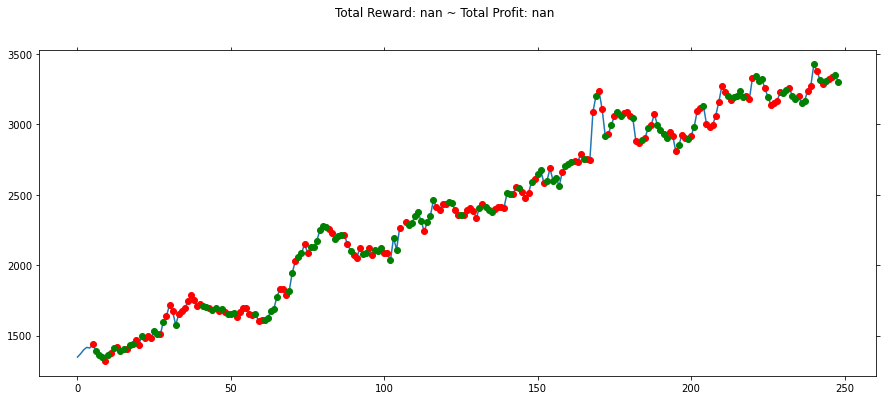

In [43]:
#Taking random steps/ Testing the env
state = env.reset() #it allows us to get initial state
while True:
    action = env.action_space.sample() #looping through each index and taking random action
    n_state,reward,done,info = env.step(action) #applying action to our environment. and storing them in variables
    if done: 
        print(f" n_state\n{n_state}\n reward\n{reward}\n  done\n{done}\n  info\n{info}\n ")
        
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [44]:
env.action_space #we have only 2 action buy and sell

Discrete(2)

# 3.1 - Add Custom Indicators

### 3.1.1 Install and Import New Dependencies

##### `We'll  be using finta`

In [45]:
# !pip install finta
from gym_anytrading.envs import StocksEnv
from finta import TA #Technical Analysis lirary


### 3.1.2 - Fix Volume Column

In [46]:
# print(df.dtypes)
# #inintially volume is object/string changing it to float
# df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(",","")))

# # (x.replace",","") stripping/removing all the commas


### 3.1.3 Calculate SMA,RSI and OBV

In [47]:
df['SMA'] = TA.SMA(df,12) #we want 12 period simple movimg average
df['RSI'] = TA.RSI(df) #relative strength index
df['OBV'] = TA.OBV(df) #on balance volume inndicator

df.fillna(0,inplace=True) #removing NAN with 0

In [48]:
df.head(15)

,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV
Date,,,,,,,,,
2020-06-18,1354.949951,1368.500000,1336.199951,1347.449951,1345.255981,591592.0,0.000000,0.000000,0.0
2020-06-19,1357.000000,1384.000000,1350.150024,1370.699951,1368.468018,894818.0,0.000000,100.000000,894818.0
2020-06-22,1380.000000,1408.750000,1371.650024,1398.300049,1396.023193,758430.0,0.000000,100.000000,1653248.0
2020-06-23,1408.000000,1422.000000,1394.400024,1416.099976,1413.794189,630401.0,0.000000,100.000000,2283649.0
2020-06-24,1424.000000,1440.000000,1401.000000,1411.800049,1409.501221,681132.0,0.000000,93.200807,1602517.0
2020-06-25,1411.800049,1444.000000,1405.500000,1437.500000,1435.159302,872300.0,0.000000,95.270575,2474817.0
2020-06-26,1453.000000,1480.000000,1376.300049,1388.150024,1385.889771,3862478.0,0.000000,58.465731,-1387661.0
2020-06-29,1381.000000,1405.550049,1359.250000,1365.050049,1362.827393,911358.0,0.000000,48.935940,-2299019.0
2020-06-30,1377.000000,1384.449951,1344.000000,1349.849976,1347.652100,759369.0,0.000000,43.868866,-3058388.0


#### 3.1.4 Create New Environment

In [49]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size #here env.frame_bound[0] = 5
    end = env.frame_bound[1] # here env.frame_bound[1] = 250
    prices = env.df.loc[:,'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['Low','Volume','SMA','RSI','OBV']].to_numpy()[start:end] 
    return prices,signal_features

In [50]:
#Creating custom env
class MyCustomEnv(StocksEnv): #inheritence is happening here
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df,window_size=12,frame_bound=(12,50)) #creating instance

In [51]:
env2.prices

array([1336.199951, 1350.150024, 1371.650024, 1394.400024, 1401.      ,
       1405.5     , 1376.300049, 1359.25    , 1344.      , 1311.      ,
       1326.25    , 1366.      , 1381.599976, 1395.      , 1387.199951,
       1390.349976, 1396.75    , 1406.550049, 1418.599976, 1440.099976,
       1427.550049, 1436.699951, 1465.25    , 1495.      , 1468.25    ,
       1478.400024, 1496.050049, 1492.050049, 1511.      , 1581.      ,
       1631.150024, 1643.5     , 1567.099976, 1568.050049, 1658.      ,
       1654.199951, 1700.550049, 1754.      , 1738.5     , 1703.099976,
       1711.5     , 1687.5     , 1686.      , 1678.800049, 1682.      ,
       1672.      , 1665.650024, 1675.400024, 1658.650024, 1635.199951])

In [52]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV
Date,,,,,,,,,
2020-06-18,1354.949951,1368.50,1336.199951,1347.449951,1345.255981,591592.0,0.0,0.000000,0.0
2020-06-19,1357.000000,1384.00,1350.150024,1370.699951,1368.468018,894818.0,0.0,100.000000,894818.0
2020-06-22,1380.000000,1408.75,1371.650024,1398.300049,1396.023193,758430.0,0.0,100.000000,1653248.0
2020-06-23,1408.000000,1422.00,1394.400024,1416.099976,1413.794189,630401.0,0.0,100.000000,2283649.0
2020-06-24,1424.000000,1440.00,1401.000000,1411.800049,1409.501221,681132.0,0.0,93.200807,1602517.0


In [53]:
env2.signal_features

array([[ 1.33619995e+03,  5.91592000e+05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.35015002e+03,  8.94818000e+05,  0.00000000e+00,
         1.00000000e+02,  8.94818000e+05],
       [ 1.37165002e+03,  7.58430000e+05,  0.00000000e+00,
         1.00000000e+02,  1.65324800e+06],
       [ 1.39440002e+03,  6.30401000e+05,  0.00000000e+00,
         1.00000000e+02,  2.28364900e+06],
       [ 1.40100000e+03,  6.81132000e+05,  0.00000000e+00,
         9.32008070e+01,  1.60251700e+06],
       [ 1.40550000e+03,  8.72300000e+05,  0.00000000e+00,
         9.52705748e+01,  2.47481700e+06],
       [ 1.37630005e+03,  3.86247800e+06,  0.00000000e+00,
         5.84657312e+01, -1.38766100e+06],
       [ 1.35925000e+03,  9.11358000e+05,  0.00000000e+00,
         4.89359402e+01, -2.29901900e+06],
       [ 1.34400000e+03,  7.59369000e+05,  0.00000000e+00,
         4.38688662e+01, -3.05838800e+06],
       [ 1.31100000e+03,  1.06666300e+06,  0.00000000e+00,
         3.59124183e+01

## Building Environment and Training

In [54]:
#Wrapping our environment inside of dummyvenEnv
env_maker = lambda:env2
# env_maker = lambda:gym.make('stocks-v0',df=df, frame_bound=(5,100),window_size=5)

env  = DummyVecEnv([env_maker])

#we are creatinng env_makr function and putting it inside DummyvecEnv wrapper



In [ ]:
#Start Training
model = A2C('MlpLstmPolicy',env,verbose=1) #multilayer-perceptron -lstm policy
model.learn(total_timesteps=100000) #starting to learn

---------------------------------
| explained_variance | -0.00459 |
| fps                | 16       |
| nupdates           | 1        |
| policy_entropy     | 0.692    |
| total_timesteps    | 5        |
| value_loss         | 5.82     |
---------------------------------
---------------------------------
| explained_variance | -0.00164 |
| fps                | 237      |
| nupdates           | 100      |
| policy_entropy     | 0.693    |
| total_timesteps    | 500      |
| value_loss         | 2.78e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.0112   |
| fps                | 246      |
| nupdates           | 200      |
| policy_entropy     | 0.693    |
| total_timesteps    | 1000     |
| value_loss         | 366      |
---------------------------------
----------------------------------
| explained_variance | -8.32e+05 |
| fps                | 253       |
| nupdates           | 300       |
| policy_entropy     | 0.693     |
| total_t

## Testing the model

In [ ]:
# env = gym.make('stocks-v0',df=df,frame_bound=(5,2000),window_size=5)
env = MyCustomEnv(df=df,window_size=12,frame_bound=(180,250))
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...] #taking observation
    #reshaping using np.newaxis to be able to work with nnon-vectorized environment 
    action,_states = model.predict(obs) #rather than using random action we are using our model and predicting which action it shoudl take
    obs,reward,done,info = env.step(action) 
    if done:
        print("info",info)
        print("action is",action)
        break
    

# Visualising our model

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()

plt.savefig("Appolo",dpi=100)
plt.show()

In [ ]:
! git add "AppoloStocksTrader.ipynb"
! git commit -m "Appolo stocks"
! git push origin main